# United Nations General Debate - Topic Modelling and Clustering (NLP):

The purpose of this case study is to semantically analyse the corpus of the UN general debates. We are more interested in the meaning and the semantic content of the speeches and arranging them topically. W want to know what the speakers are talking about and answer the questions like: 
1. Is there a structure in the document copus?
2. What are the topics? 
3. which of them is most prominent? etc.

In [ ]:
import sys, os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['axes.grid'] = False

In [ ]:
df = pd.read_csv(
    '/content/drive/MyDrive/Datasets/un-general-debates.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   session  7507 non-null   int64 
 1   year     7507 non-null   int64 
 2   country  7507 non-null   object
 3   text     7507 non-null   object
dtypes: int64(2), object(2)
memory usage: 234.7+ KB


In [ ]:
print(repr(df.iloc[2666]['text'][0:200]))

'On the eve of the\nfiftieth anniversary of the United Nations, the\nrepresentatives of the world’s nations are gathered here\nwith hearts full of hope for a better future, as well as for\nthe cause of the'


In [ ]:
print(repr(df.iloc[4729]['text'][0:200]))

'\ufeffMr. President, I should like first of all, on behalf of the Bahamas Government and its people, to congratulate you on your election as President of the thirty-fifth session of the General Assembly. Y'


In [ ]:
df['paragraphs'] = df['text'].map(
    lambda text: re.split('[.?!]\s*\n', text)
)
df['no_of_paragraphs'] = df['paragraphs'].map(len)

In [ ]:
df.head()

,session,year,country,text,paragraphs,no_of_paragraphs
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...,[﻿It is indeed a pleasure for me and the membe...,30
1,44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ...","[﻿\nMay I begin by congratulating you. Sir, on...",25
2,44,1989,NER,"﻿\nMr. President, it is a particular pleasure ...","[﻿\nMr. President, it is a particular pleasure...",61
3,44,1989,URY,﻿\nDuring the debate at the fortieth session o...,[﻿\nDuring the debate at the fortieth session ...,36
4,44,1989,ZWE,﻿I should like at the outset to express my del...,[﻿I should like at the outset to express my de...,35


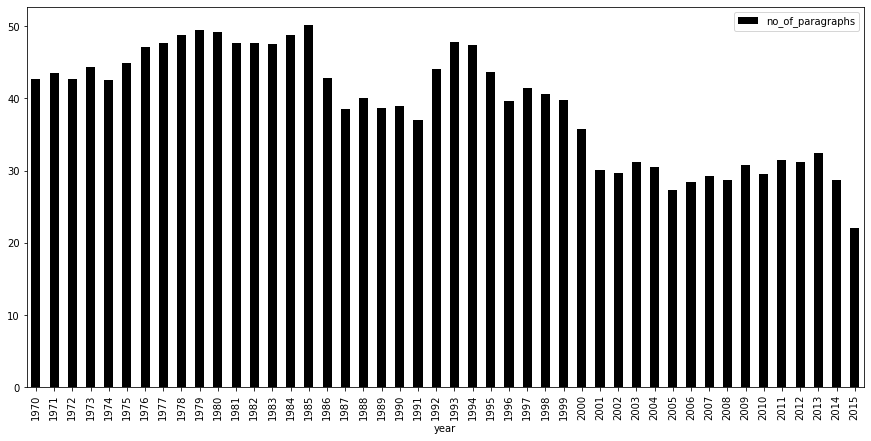

In [ ]:
df.groupby('year').agg(
    {
        'no_of_paragraphs':'mean'
    }
).plot.bar(figsize=(15,7), color='black')

## Topic Modelling:

Topic Modelling is a machine learning method that need vectorized data. Topic modelling methods start with the document-term matrix.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

In [ ]:
tfidf_text_vectorizer = TfidfVectorizer(
    stop_words=stopwords, min_df=5, max_df=0.7
)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  % sorted(inconsistent)


(7507, 24611)

For the paragraphs, it’s a bit more complicated as we have to flatten the list first. In the same step, we omit empty paragraphs

In [ ]:
paragraph_df = pd.DataFrame([
    {'text': paragraph, 'year':year}
     for paragraphs, year in \
    zip(df['paragraphs'], df['year']) 
    for paragraph in paragraphs if paragraph
])

In [ ]:
tfidf_para_vectorizer = TfidfVectorizer(
    stop_words=stopwords, min_df=5, max_df=0.7,
)
tfidf_para_vectors = tfidf_para_vectorizer.fit_transform(
    paragraph_df['text']
)
tfidf_para_vectors.shape

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  % sorted(inconsistent)


(282210, 25165)

## Non-Negative Matrix Factorization (NMF):

### Creating Topic Model using NMF for Documents:

In [ ]:
from sklearn.decomposition import NMF

nmf_text_model = NMF(
    n_components=10, random_state=42
)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


In [ ]:
def display_topics(model, features, no_top_words=5):
    for topic, word in enumerate(model.components_):
        total = word.sum()
        largest = word.argsort()[::-1]
        print('\nTopic %02d' % topic)
        for i in range(0,no_top_words):
            print(' %s (%2.2f)' % (features[largest[i]],
                    abs(word[largest[i]]*100.0/total)))

In [ ]:
display_topics(nmf_text_model,
        tfidf_text_vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



Topic 00
 co (0.79)
 operation (0.65)
 disarmament (0.36)
 nuclear (0.34)
 relations (0.25)

Topic 01
 terrorism (0.38)
 challenges (0.32)
 sustainable (0.30)
 millennium (0.29)
 reform (0.28)

Topic 02
 africa (1.15)
 african (0.82)
 south (0.63)
 namibia (0.36)
 delegation (0.30)

Topic 03
 arab (1.02)
 israel (0.89)
 palestinian (0.60)
 lebanon (0.54)
 israeli (0.54)

Topic 04
 american (0.33)
 america (0.31)
 latin (0.31)
 panama (0.21)
 bolivia (0.21)

Topic 05
 pacific (1.55)
 islands (1.23)
 solomon (0.86)
 island (0.82)
 fiji (0.71)

Topic 06
 soviet (0.81)
 republic (0.78)
 nuclear (0.68)
 viet (0.64)
 socialist (0.63)

Topic 07
 guinea (4.26)
 equatorial (1.75)
 bissau (1.53)
 papua (1.47)
 republic (0.57)

Topic 08
 european (0.61)
 europe (0.44)
 cooperation (0.39)
 bosnia (0.34)
 herzegovina (0.30)

Topic 09
 caribbean (0.98)
 small (0.66)
 bahamas (0.63)
 saint (0.63)
 barbados (0.61)


Topic 00 and Topic 01 look really promising as people are talking about nuclear disarmament and terrorism. These are definitely real topics in the UN general debates.

The subsequent topics, however, are more or less focused on different regions of the world. This is due to speakers mentioning primarily their own country and neighboring countries. This is especially evident in Topic 03, which reflects the conflict in the Middle East.

It’s also interesting to take a look at the percentages with which the words contribute to the topics. Due to the large number of words, the individual contributions are quite small, except for  guinea  in Topic 07.

In [ ]:
W_text_matrix.sum(axis=0)/W_text_matrix.sum()*100

array([11.13926287, 17.07197914, 13.64509781, 10.18184685, 11.43081404,
        5.94072639,  7.89602474,  4.17282682, 11.83871081,  6.68271054])

We can easily see that there are smaller and larger topics but basically no outliers. Having an even distribution is a quality indicator.

### Creating Topic Model for Paragraphs Using NMF:

In [ ]:
nmf_para_model = NMF(
    n_components=10, random_state=42
)
W_para_matrix = nmf_para_model.fit_transform(tfidf_para_vectors)
H_para_matrix = nmf_para_model.components_

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


In [ ]:
display_topics(nmf_para_model, 
        tfidf_para_vectorizer.get_feature_names())


Topic 00
 nations (5.63)
 united (5.52)
 organization (1.27)
 states (1.03)
 charter (0.93)

Topic 01
 general (2.87)
 session (2.83)
 assembly (2.81)
 mr (1.98)
 president (1.81)

Topic 02
 countries (4.44)
 developing (2.49)
 economic (1.49)
 developed (1.35)
 trade (0.92)

Topic 03
 people (1.36)
 peace (1.34)
 east (1.28)
 middle (1.17)
 palestinian (1.14)

Topic 04
 nuclear (4.93)
 weapons (3.27)
 disarmament (2.01)
 treaty (1.70)
 proliferation (1.46)

Topic 05
 rights (6.49)
 human (6.18)
 respect (1.15)
 fundamental (0.86)
 universal (0.82)

Topic 06
 africa (3.83)
 south (3.32)
 african (1.70)
 namibia (1.38)
 apartheid (1.19)

Topic 07
 security (6.13)
 council (5.88)
 permanent (1.50)
 reform (1.48)
 peace (1.30)

Topic 08
 international (2.05)
 world (1.50)
 community (0.92)
 new (0.77)
 peace (0.67)

Topic 09
 development (4.47)
 sustainable (1.18)
 economic (1.07)
 social (1.00)
 goals (0.93)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Compared to the previous results for topic modeling speeches, we have almost lost all countries or regions except for South Africa and the Middle East. These are due to the regional conflicts that sparked interest in other parts of the world. Topics in the paragraphs like “Human rights,” “international relations,” “developing countries,” “nuclear weapons,” “security council,” “world peace,” and “sustainable development” (the last one probably occurring only lately) look much more reasonable compared to the topics of the speeches. Taking a look at the percentage values of the words, we can observe that they are dropping much faster, and the topics are more pronounced.



## Latent Semantic Analysis:

### Creating Topic Model for Paragraphs with Singular Value Decompposition:


In [ ]:
from sklearn.decomposition import TruncatedSVD

svd_para_model = TruncatedSVD(
    n_components=10, random_state=21
)
W_svd_para_matrix = svd_para_model.fit_transform(tfidf_para_vectors)
H_svd_para_matrix = svd_para_model.components_

In [ ]:
display_topics(svd_para_model,
    tfidf_para_vectorizer.get_feature_names())


Topic 00
 nations (0.67)
 united (0.65)
 international (0.58)
 peace (0.46)
 world (0.46)

Topic 01
 general (13.99)
 assembly (13.06)
 session (12.90)
 mr (9.99)
 president (8.56)

Topic 02
 countries (19.27)
 development (14.72)
 economic (14.01)
 developing (13.08)
 session (10.36)

Topic 03
 nations (4.42)
 united (4.07)
 development (0.95)
 organization (0.85)
 charter (0.80)

Topic 04
 nuclear (21.16)
 weapons (14.05)
 disarmament (9.09)
 treaty (7.24)
 proliferation (6.33)

Topic 05
 rights (28.85)
 human (28.17)
 nuclear (9.02)
 weapons (6.28)
 respect (4.87)

Topic 06
 africa (8.90)
 south (8.32)
 united (3.94)
 african (3.85)
 nations (3.49)

Topic 07
 council (14.89)
 security (13.39)
 africa (8.45)
 south (5.97)
 african (3.87)

Topic 08
 world (79.93)
 peace (55.39)
 international (53.39)
 africa (33.49)
 new (30.27)

Topic 09
 development (135.06)
 sustainable (43.86)
 peace (36.57)
 goals (33.70)
 africa (32.57)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Most of the resulting topics are surprisingly similar to those of the nonnegative matrix factorization. However, the Middle East conflict does not appear as a separate topic this time. As the topic-word mappings can also have negative values, the normalization varies from topic to topic. Only the relative sizes of the words constituting the topics are relevant.

In [ ]:
svd_para_model.singular_values_

array([71.7166257 , 39.41220471, 36.59105022, 34.95106751, 33.35293234,
       31.56326223, 29.97990651, 28.79502976, 27.12363994, 26.87466959])

The sizes of the topics also correspond quite nicely with the ones from the NMF method for the paragraphs.
The sizes of the topics also correspond quite nicely with the ones from the NMF method for the paragraphs.

## Latent Dirichlet Allocation (LDA):

LDA is arguably the most prominent mehtod of topic modelling.

LDA views each document as consisting of different topics. In other words, documents is a mix of different topics. In the same waym topics are mixed from words. To keep the number of topics per document low and to have finally a few important words constituing the topics.

### Creating Topic Model for Paragraphs with LDA:

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


count_para_vectorizer = CountVectorizer(
    stop_words=stopwords, min_df=5, max_df=0.7
)
count_para_vectors = count_para_vectorizer.fit_transform(paragraph_df['text'])

lda_para_model = LatentDirichletAllocation(
    n_components=10, random_state=42
)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  % sorted(inconsistent)


KeyboardInterrupt: ignored

In [ ]:
!pip install pyldavis

In [ ]:
import pyLDAvis.sklearn

lda_display = pyLDAvis.sklearn.prepare(
    lda_para_model, count_para_vectors,
    count_para_vectorizer, sort_topics=False
)
pyLDAvis.display(lda_display)

In [ ]:
from wordcloud import WordCloud

In [ ]:
def wordcloud_topics(model, features, no_top_words=40):
    for topic, words in enumerate(model.components_):
        size= {}
        largest = words.argsort()[::-1]
        for i in range(0,no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color='white', max_words=100,
                       width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')

In [ ]:
wordcloud_topics(nmf_para_model, 
        tfidf_para_vectorizer.get_feature_names())

In [ ]:
wordcloud_topics(lda_para_model, 
        count_para_vectorizer.get_feature_names())

### Calculating Topic Distribution of Documents and Time Evolution:

In [ ]:
before_1990 = np.array(paragraph_df['year'] < 1990)
after_1990 = ~ before_1990

In [ ]:
W_para_matrix_early = nmf_para_model.transform(
    tfidf_para_vectors[before_1990])
W_para_matrix_late = nmf_para_model.transform(
    tfidf_para_vectors[after_1990])
print(W_para_matrix_early.sum(axis=0)/ W_para_matrix_early.sum()*100.0)
print(W_para_matrix_late.sum(axis=0)/W_para_matrix_late.sum()*100.0)


In [ ]:
from tqdm.auto import tqdm
year_data = []
for year in tqdm(np.unique(np.unique(paragraph_df['year']))):
    W_year = nmf_para_model.transform(tfidf_para_vectors[np.array(paragraph_df['year']== year)])
    year_data.append([year] + list(
        W_year.sum(axis=0)/W_year.sum()*100.0
    ))

In [ ]:
topic_names = []
voc = tfidf_para_vectorizer.get_feature_names()
for topic in nmf_para_model.components_:
    important = topic.argsort()
    top_word = voc[important[-1]] + ' '+ voc[important[-2]]
    topic_names.append('Topic' + top_word)

In [ ]:
df_year = pd.DataFrame(year_data, 
            columns=['year'] + topic_names
).set_index('year')
df_year.plot.area(figsize=(15,9))

## Clustering to Uncover the Structure of Text Data:

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans_text = KMeans(n_clusters=10, random_state=42)
kmeans_text.fit(tfidf_para_vectors)

KMeans(n_clusters=10, random_state=42)

In [ ]:
sizes = []
for k in range(10):
    sizes.append({'cluster':k,
            'size':np.sum(kmeans_text.labels_ ==k)})


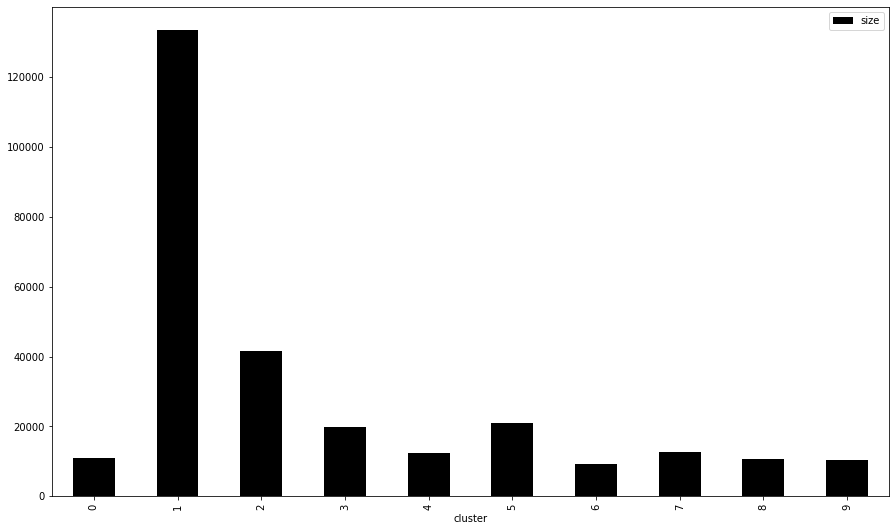

In [ ]:
pd.DataFrame(sizes).set_index('cluster').plot.bar(
    figsize=(15,9), color='black')

In [ ]:
from wordcloud import WordCloud

In [ ]:
np.unique(kmeans_text.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([ 11110, 133261,  41635,  19953,  12411,  21051,   9138,  12715,
         10568,  10368]))

In [ ]:
def wordcloud_clusters(model, vectors, features, no_top_words=40):
    for cluster in np.unique(model.labels_):
        size = {}
        words = vectors[model.labels_ == cluster].sum(axis=0).A[0]
        largest = words.argsort()[::-1]
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color='white',
                max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


IndexError: ignored

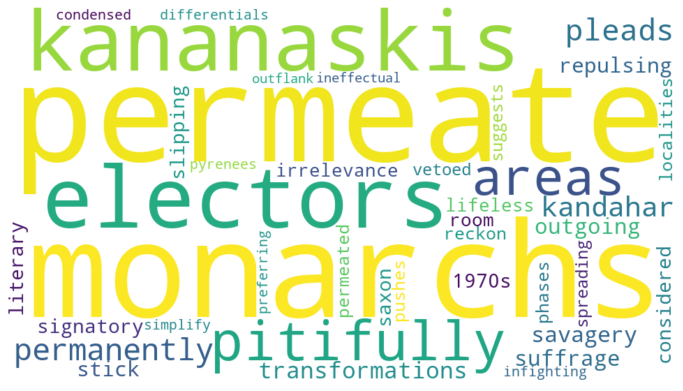

In [ ]:
wordcloud_clusters(
    kmeans_text, tfidf_para_vectors, 
    tfidf_text_vectorizer.get_feature_names()
)